In [65]:
%pip install tqdm scikit-learn numpy python-dateutil flask pandas matplotlib

Note: you may need to restart the kernel to use updated packages.


In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import os
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression

# Raport z budowy modeli

## Selekcja atrybutów
Aby wybrać atrybuty wykorzystywane do modelowania przeanalizowano wagi modelu regresji logicznej dla znormalizowanych danych.
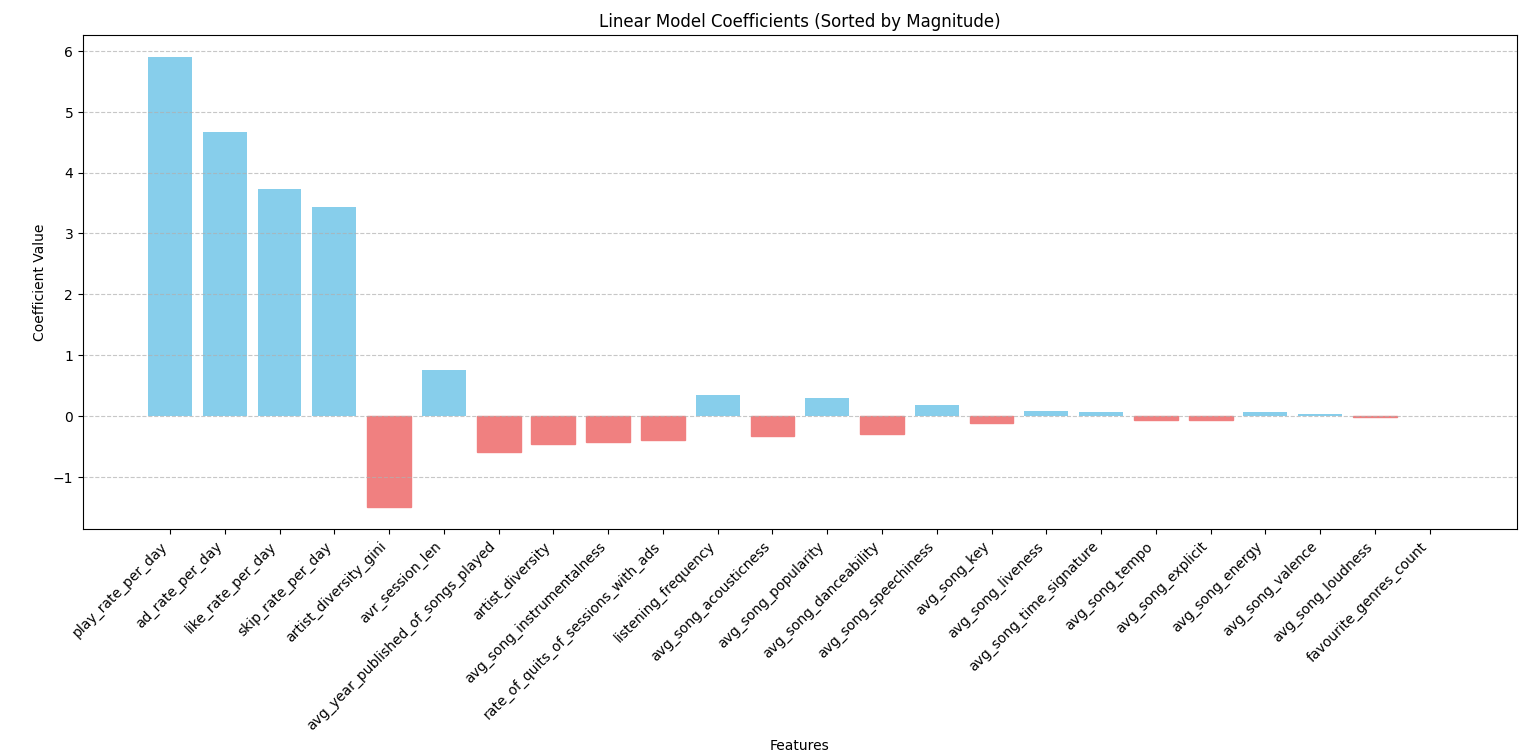
Jak widać na powyższym wykresie najbardziej znaczące są atrybuty odnoszące się do zachowań użytkowanika na platformie. Najmniej istotne są parametry mówiące o typie muzyki słuchanej przez użytkownika. Po przeanalizowaniu wag modelu wybrano 6 najbardziej istotnych atrybutów do wykorzystania w dalszym modelowaniu. Dzięki zmniejszeniu ilości używanych atrybutów łatwiejsze będzie utrzymanie modelu a także korzystanie z niego.

### Analiza jakości modelu po selekcji atrybutów
Do analizy jakości modelu po selekcji atrybutów wykorzystano pierwszą połowę zbioru danych aby uniknąć ich wpływu na zbiór testowy.

In [68]:

X_processed_full = pd.read_csv('data/processed_X.csv')
X_all_attributes_full = pd.read_csv('data/all_attributes_X.csv')
Y_full = pd.read_csv('data/processed_Y.csv')

train_ratio = 0.8  # 80% for training and 20% for validation
full_data_ratio = 0.5
indices = np.arange(int(full_data_ratio*len(Y_full)))
np.random.shuffle(indices)

train_size = int(len(indices) * train_ratio)
train_indices = indices[:train_size]
val_indices = indices[train_size:]

Xp_train = X_processed_full.iloc[train_indices]
Xall_train = X_all_attributes_full.iloc[train_indices]
Y_train = Y_full.iloc[train_indices]

Xp_val = X_processed_full.iloc[val_indices]
Xall_val = X_all_attributes_full.iloc[val_indices]
Y_val = Y_full.iloc[val_indices]



scaler = StandardScaler()
Xp_train_scaled = scaler.fit_transform(Xp_train)
Xp_val_scaled = scaler.transform(Xp_val)


scaler = StandardScaler()

Xall_train_scaled = scaler.fit_transform(Xall_train)
Xall_val_scaled = scaler.transform(Xall_val)

model = LogisticRegression()
model.fit(Xp_train_scaled, Y_train)

print("Accuracy on Selected Attributes: ", accuracy_score(Y_val, model.predict(Xp_val_scaled)))
model = LogisticRegression()
model.fit(Xall_train_scaled, Y_train)
print("Accuracy on All generated Attributes: ", accuracy_score(Y_val, model.predict(Xall_val_scaled)))

Accuracy on Selected Attributes:  0.8133333333333334
Accuracy on All generated Attributes:  0.83


d:\SyncVestigat\2_Studia\5 sem\IUM\gitlaby\git_vpo_dok_wstep\ium-projekt-mast-have-24z\.venv\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\SyncVestigat\2_Studia\5 sem\IUM\gitlaby\git_vpo_dok_wstep\ium-projekt-mast-have-24z\.venv\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### Wnioski
Jak widać po selekcji atrybutów model osiąga lepszą jakość niż przy wszystkich atrybutach a dodatkowo łatwiej jest go utrzymać w produkcji. Eksperyment ten miał jedynie pokazać że wyselekcjonowane atrybuty zachowują informatywność danych a nie samą jakość modeli. Aby uniknąć kontaminacji danych testowych stanowczo zmniejszono zbiory treningowe oraz testowe w tym eksperymencie ponieważ metody otrzymywania danych do budowy końcowego modelu są inne niż przyjęte tutaj.

## Porównanie wytrenowanych modeli
### Model podstawowy - Regresja logistyczna
Training data
Accuracy: 0.8035555555555556
ROC AUC: 0.7792473694710045
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.90      0.85      1343
           1       0.82      0.65      0.73       907

    accuracy                           0.80      2250
   macro avg       0.81      0.78      0.79      2250
weighted avg       0.81      0.80      0.80      2250

Validation data
Accuracy: 0.8044444444444444
ROC AUC: 0.7872229674267754
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.94      0.84       251
           1       0.89      0.64      0.74       199

    accuracy                           0.80       450
   macro avg       0.83      0.79      0.79       450
weighted avg       0.82      0.80      0.80       450

## Dobór hiperparametrów modelu zaawansowanego

In [69]:
def load_data(base_path='data/'):
    X_train = pd.read_csv(f'{base_path}X_train.csv')
    X_val = pd.read_csv(f'{base_path}X_val.csv')
    Y_train = pd.read_csv(f'{base_path}Y_train.csv')
    Y_val = pd.read_csv(f'{base_path}Y_val.csv')
    return X_train, X_val, Y_train, Y_val

X_train, X_val, Y_train, Y_val = load_data()
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

In [ ]:
n_estimators_range = [*range(1,100,1)]
number_to_sample = 20
criterions = ["gini", "entropy", "log_loss"]

for criterion in tqdm(criterions,leave=False):
    train_scores = []
    val_scores = []
    for n_estimators in tqdm(n_estimators_range,leave=False):
        train_score = []
        val_score = []
        for i in range(number_to_sample):
            rf_model = RandomForestClassifier(criterion=criterion,n_estimators=n_estimators, random_state=i+30)
            rf_model.fit(X_train_scaled, Y_train.values.ravel())

            train_pred = rf_model.predict(X_train_scaled)
            val_pred = rf_model.predict(X_val_scaled)
            train_score.append(accuracy_score(Y_train, train_pred))
            val_score.append(accuracy_score(Y_val, val_pred))

        train_scores.append(np.mean(train_score))
        val_scores.append(np.mean(val_score))

    fig, ax1 = plt.subplots(figsize=(10, 6))

    ax1.plot(n_estimators_range, train_scores, '-', color='blue')
    ax1.set_xlabel('Number of Trees')
    ax1.set_ylabel('Training Accuracy', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    ax1.grid(True)

    ax2 = ax1.twinx()

    ax2.plot(n_estimators_range, val_scores, '-', color='red')
    ax2.set_ylabel('Validation Accuracy', color='red')
    ax2.tick_params(axis='y', labelcolor='red')

    plt.title(f'Random Forest  Model - {criterion} criterion')
    plt.show()


KeyboardInterrupt: 